# CLV: Customer Lifetime value

For example if the customer spends 100 bucks every year for 15 years before leaving the company.

Amount spend by company for acquiring the customer 50 bucks.

CLV = 100 * 15 - 50 = 1450

**CLV = Expected number of transactions x Revenue per transaction x margin**

Expected number of transactions will be calculated using BG/NBD model

Revenue per transaction will be calculated using gamma gamma model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rtl_df = pd.read_csv('Online Retail.csv',encoding = 'cp1252')
rtl_df.head()

,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
rtl_df.shape

(541909, 8)

In [4]:
rtl_df.isnull().sum(axis=0)

ï»¿InvoiceNo         0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
dtype: int64

In [5]:
#Since our analysis is based on customer we will remove the missing values
#Remove missing values for customer ID column and ignore missing values for description column
rtl_df = rtl_df[pd.notnull(rtl_df['CustomerID'])]

In [6]:
rtl_df = rtl_df[(rtl_df['Quantity']>0)]

In [7]:
#Converting date from string to datetime
import datetime as dt
rtl_df['InvoiceDate']=pd.to_datetime(rtl_df['InvoiceDate'],format = '%m/%d/%Y %H:%M').dt.date

In [8]:
rtl_df['TotalAmount'] = rtl_df['Quantity']*rtl_df['UnitPrice']

In [9]:
necessary_col=['CustomerID','InvoiceDate','TotalAmount']
rtl_df=rtl_df[necessary_col]
rtl_df.head()

,CustomerID,InvoiceDate,TotalAmount
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [10]:
rtl_df.shape

(397924, 3)

In [11]:
rtl_df['CustomerID'].nunique()

4339

In [12]:
last_order_date = rtl_df['InvoiceDate'].max()
print(last_order_date)
print('----------------')
print(rtl_df[rtl_df['CustomerID']==12346])

2011-12-09
----------------
       CustomerID InvoiceDate  TotalAmount
61619     12346.0  2011-01-18      77183.6


In [13]:
import lifetimes
lf_df = lifetimes.utils.summary_data_from_transaction_data(rtl_df,'CustomerID','InvoiceDate',monetary_value_col='TotalAmount')
lf_df.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
------------------------
% of one time buyers 35.7


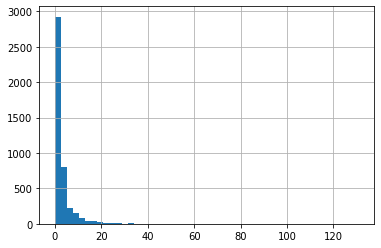

In [14]:
lf_df['frequency'].hist(bins=50)
print(lf_df['frequency'].describe())
print('------------------------')
one_time_buyer = round(sum(lf_df['frequency']==0)/float(len(lf_df))*100,2)
print('% of one time buyers',one_time_buyer)

In [15]:
#Frequency and recency analysis using BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lf_df['frequency'],lf_df['recency'],lf_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [16]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


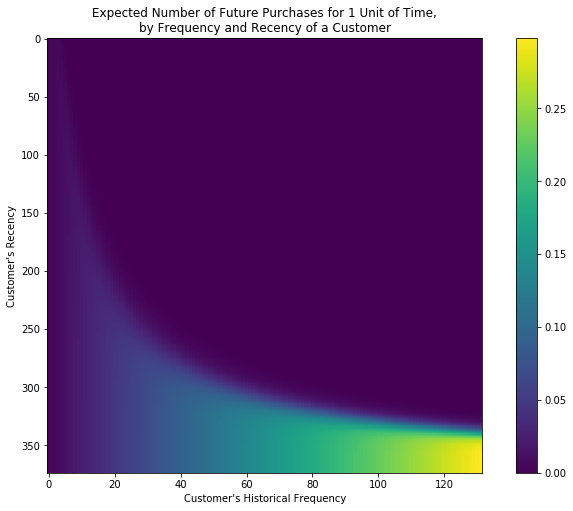

In [17]:
fig=plt.figure(figsize=(12,8))
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

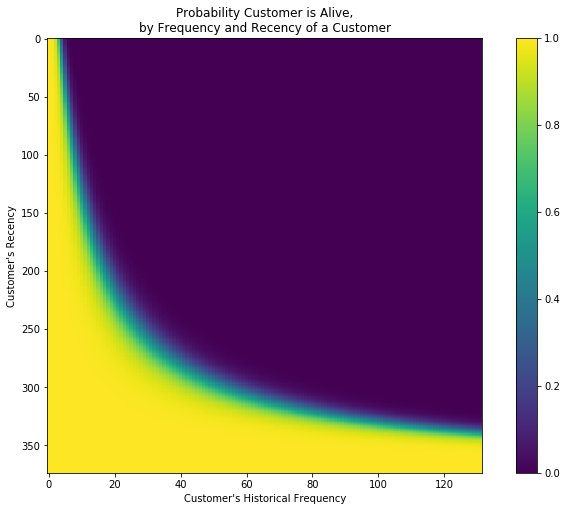

In [18]:
fig=plt.figure(figsize=(12,8))
lifetimes.plotting.plot_probability_alive_matrix(bgf)

In [19]:
#Predict number of future transactions for customers in next 10 days

lf_df['future_txn_10days'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(10,lf_df['frequency'],lf_df['recency'],lf_df['T']),3)
lf_df.sort_values(by='future_txn_10days',ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,future_txn_10days
0,14911.0,131.0,372.0,373.0,1093.661679,2.983
1,12748.0,113.0,373.0,373.0,298.360885,2.576
2,17841.0,111.0,372.0,373.0,364.452162,2.530
3,15311.0,89.0,373.0,373.0,677.729438,2.033
4,14606.0,88.0,372.0,373.0,135.890114,2.010
5,12971.0,70.0,369.0,372.0,159.211286,1.606
6,13089.0,65.0,367.0,369.0,893.714308,1.503
7,14527.0,53.0,367.0,369.0,155.016415,1.229
8,13798.0,52.0,371.0,372.0,706.650962,1.198
9,16422.0,47.0,352.0,369.0,702.472340,1.092


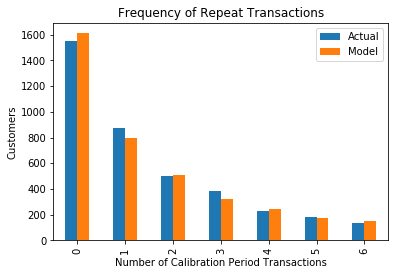

In [20]:
lifetimes.plotting.plot_period_transactions(bgf)

Actual vs model based predicted values. As the bar graph are very close our model is performing well.

In [32]:
#Predict number of future transactions for let's say 15
customer = lf_df.loc[14911]
round(bgf.predict(15,customer['frequency'],customer['recency'],customer['T']),2)

4.47

**Gamma Gamma model relies on the assumption that there is no correlation between monetary value and frequency**

In [33]:
lf_df[['monetary_value','frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


As we can see there is no significant correlation between monetary value and frequency we can move ahead with training out gamma gamma model

In [35]:
#Shortlisting customers who had atleast 2 transaction with the company
shortlist = lf_df[lf_df['frequency']>0]
print(shortlist.head())
print('Number of returning customers are:',len(shortlist))

            frequency  recency      T  monetary_value  future_txn_10days
CustomerID                                                              
12347.0           6.0    365.0  367.0      599.701667              0.157
12348.0           3.0    283.0  358.0      301.480000              0.090
12352.0           6.0    260.0  296.0      368.256667              0.187
12356.0           2.0    303.0  325.0      269.905000              0.072
12358.0           1.0    149.0  150.0      683.200000              0.083
Number of returning customers are: 2790


In [36]:
gg = lifetimes.GammaGammaFitter(penalizer_coef=0)
gg.fit(shortlist['frequency'],shortlist['monetary_value'])
gg

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [41]:
#Now we can view average transaction value for each customer
lf_df['pred_avg_trns_value']=round(gg.conditional_expected_average_profit(lf_df['frequency'],lf_df['monetary_value']),2)

In [42]:
lf_df['CLV']=round(gg.customer_lifetime_value(bgf,lf_df['frequency'],
                          lf_df['recency'],lf_df['T'],
                          lf_df['monetary_value'],time=12,discount_rate=0.01),2)
lf_df.sort_values(by='CLV',ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,future_txn_10days,CLV,pred_avg_trns_value
0,14646.0,44.0,353.0,354.0,6366.705909,1.060,222128.93,6213.28
1,18102.0,25.0,367.0,367.0,9349.477200,0.592,178895.33,8951.86
2,16446.0,1.0,205.0,205.0,168469.600000,0.067,175531.47,78051.29
3,17450.0,26.0,359.0,367.0,7404.690385,0.615,147476.62,7105.09
4,14096.0,16.0,97.0,101.0,4071.434375,0.990,127589.20,3823.47
5,14911.0,131.0,372.0,373.0,1093.661679,2.983,109442.13,1087.70
6,12415.0,15.0,313.0,337.0,7860.210000,0.390,96290.23,7323.92
7,14156.0,42.0,362.0,371.0,2787.081667,0.973,89410.33,2723.13
8,17511.0,27.0,371.0,373.0,3305.060741,0.630,67660.41,3185.63
9,16029.0,38.0,335.0,373.0,2034.808421,0.876,58729.62,1986.70


CustomerID with 14646 will purchase products worth 222128.93 in the next 12 month